In [14]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Convergence test
## [toolbox] 


We simulate a series of fake sequence from a unifromly distributed joined space of k and A

Simulate the reacted fraction given error 50%, floored by 0

use least-squared method to fit the dataset with different initial k, A value for 20 times

calculate the std(k)/std(kA)

In [2]:
import numpy as np
from k_seq.data import simu
from k_seq.model import kinetic

In [79]:
def simu_seq_reacted_frac(param, c, kinetic_model, percent_error=0):
    import pandas as pd
    import numpy as np
    
    if isinstance(param, pd.Series):
        param = param.to_dict()
    if isinstance(c, (list, np.ndarray, tuple)):
        c = pd.Series(data=c, index=np.arange(len(c)) + 1)
    reacted_frac = kinetic_model(**param, c=c)
    if percent_error:
        reacted_frac = np.random.normal(loc=reacted_frac, scale=reacted_frac * percent_error)
        reacted_frac[reacted_frac < 0] = 0
    return pd.Series(data=reacted_frac, index=c.index)


In [84]:
def simulate_reacted_frac(df_seq_param=None, c=None, kinetic_model=None, percent_error=0):
    import pandas as pd
    
    if not df_seq_param:
        seed = 23
        df_seq_param = pd.DataFrame(
            {'A':simu.DistGenerators.uniform(low=0, high=1, size=int(1e4), seed=seed),
             'k':10 ** simu.DistGenerators.uniform(low=-1, high=3, size=int(1e4))})
    if not c:
        c = pd.Series(data=np.repeat([1250, 250, 50, 10, 2], 3) * 1e-6, index=np.arange(15) + 1)
    if not kinetic_model:
        from k_seq.model import kinetic
        kinetic_model = kinetic.BYOModel.reacted_frac
    
    from functools import partial
    partial_func = partial(simu_seq_reacted_frac, c=c, kinetic_model=kinetic_model, percent_error=percent_error)
    reacted_frac = df_seq_param.apply(partial_func, axis=1)
    return reacted_frac, c, df_seq_param

In [85]:
reacted_frac, c, df_seq_param = simulate_reacted_frac()

In [83]:
from k_seq.estimator import least_square
fitter = least_square.SingleFitter(x_data=c, y_data=reacted_frac.loc[ix],
                                   model=kinetic.BYOModel.reacted_frac, name=ix,
                                   sigma=None, bounds=[[0, 0], [np.inf, 1]], init_guess=None,
                 opt_method='trf', exclude_zero=False, metrics={'kA': kA}, rnd_seed=None, grouper=None,
                 bootstrap_num=0, bs_record_num=0, bs_method='pct_res', curve_fit_params=None,
                 save_to=None, overwrite=False, silent=False)

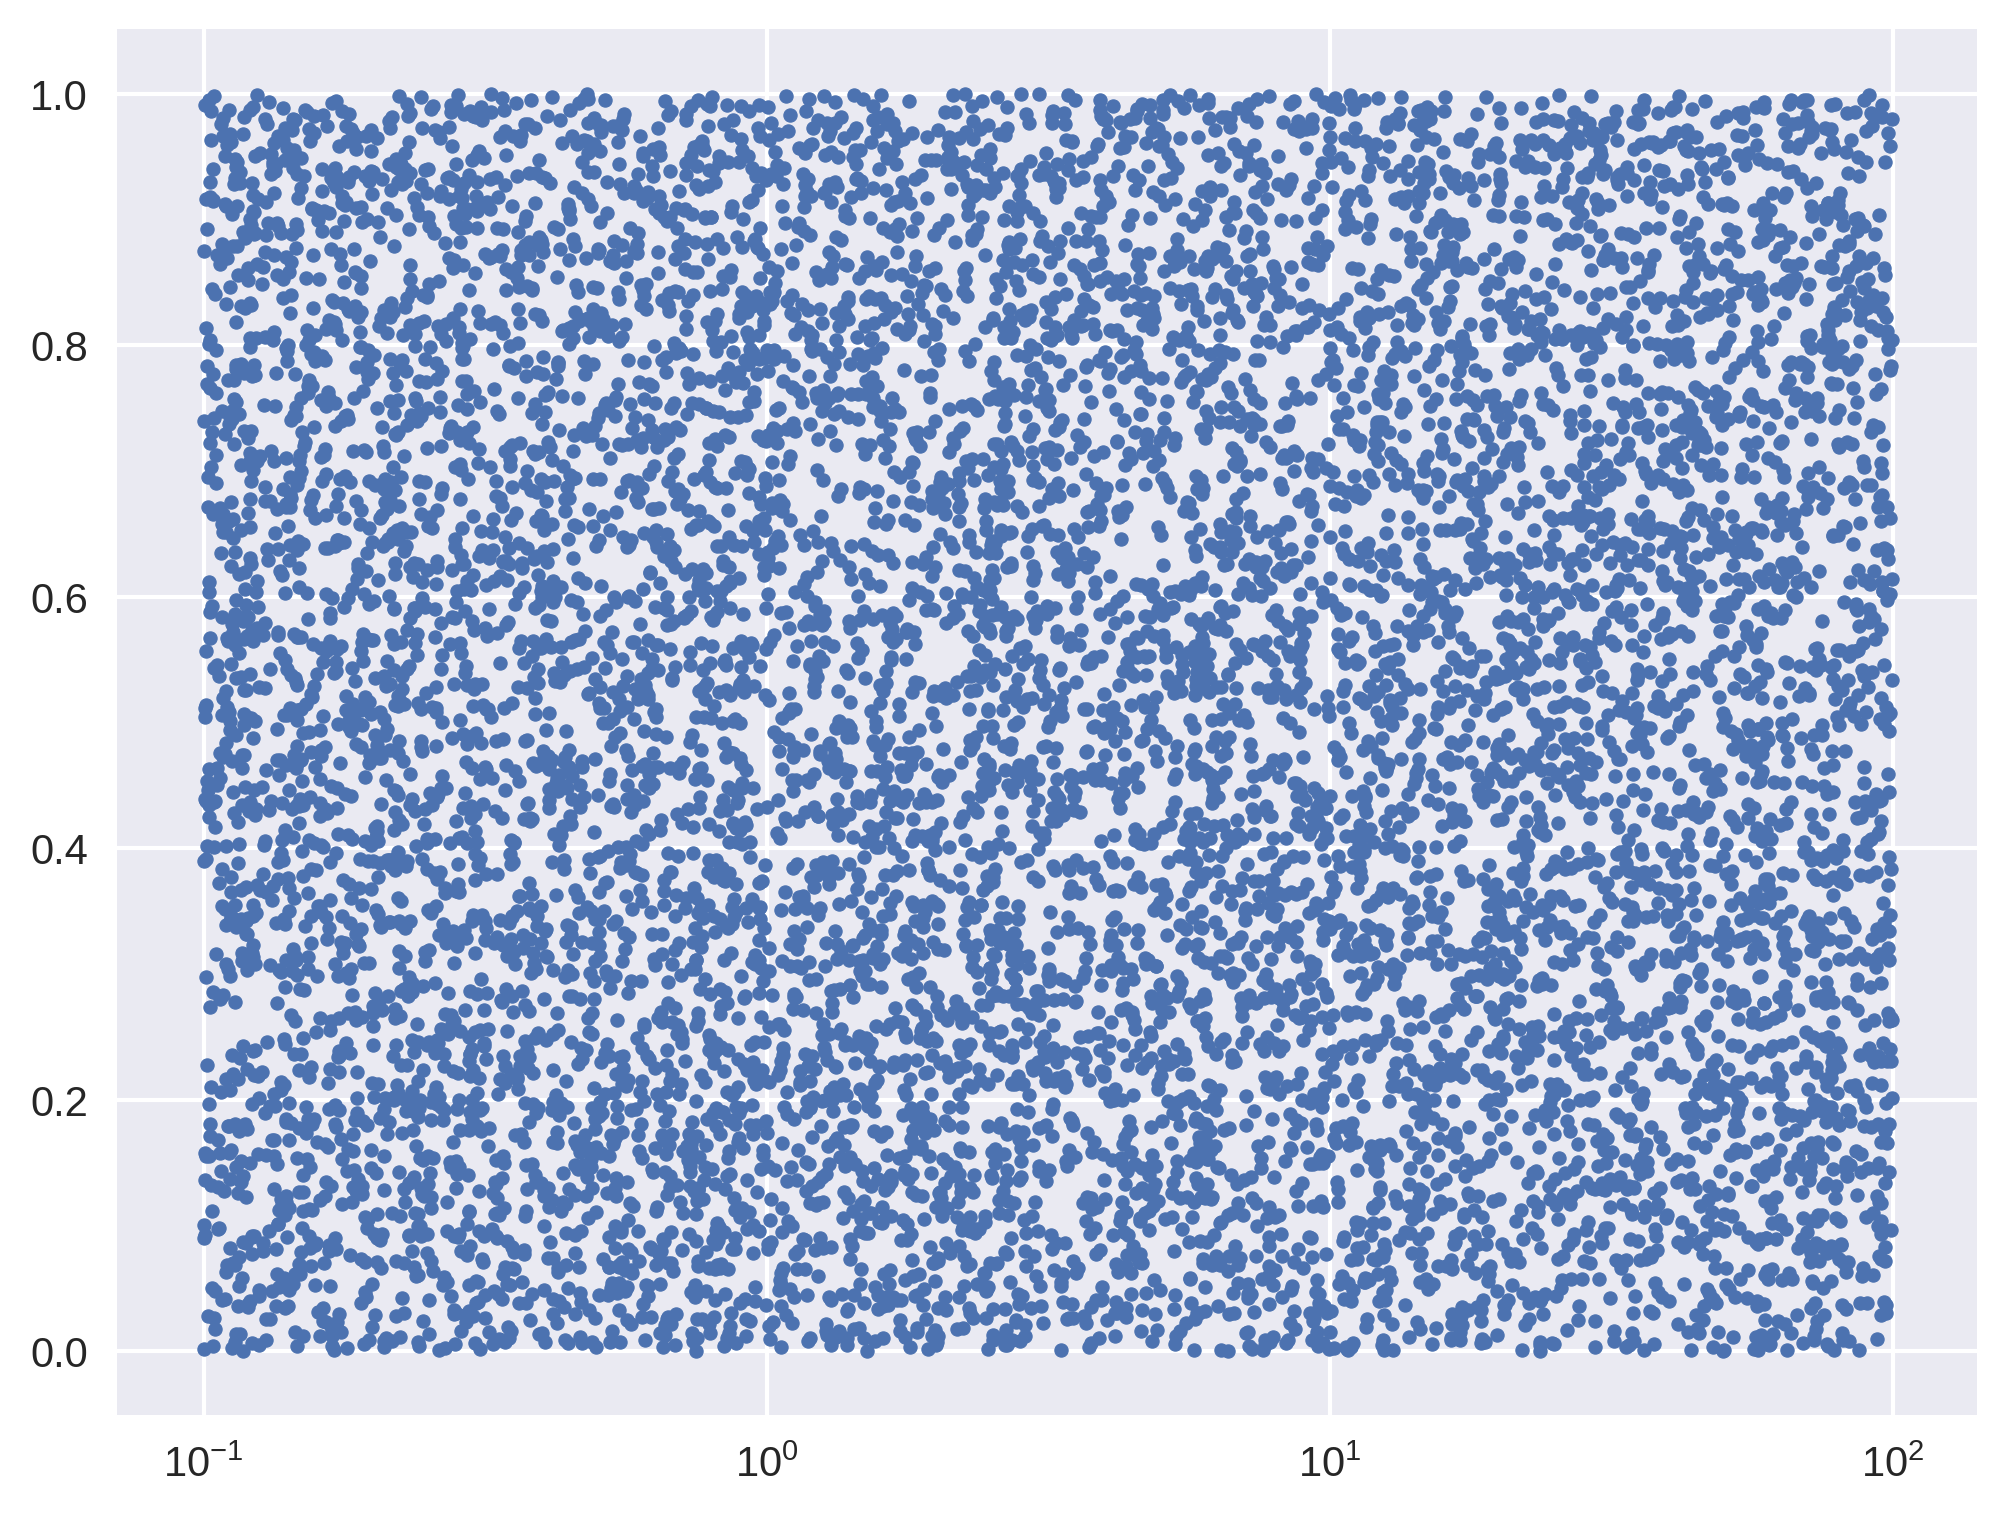

In [50]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.scatter(x=data['k'], y=data['a'], s=10)
ax.set_xscale('log')
plt.show()

In [523]:
model = kinetic
def model(x, A, k):
    return A * (1 - np.exp(-0.479 * 90 * k * x))

def mse(x, y_, A, k):
    y_true = model(x, A, k)
    return np.mean((y_ - y_true)**2)

def param_scan(x, y, kmin, kmax, Amin, Amax, res, klog=True, Alog=False):

    import numpy as np
    
    if Alog:
        xValues = np.logspace(np.log10(Amin), np.log10(Amax), res+1)
    else:
        xValues = np.linspace(Amin, Amax, res+1)
    
    if klog:
        yValues = np.logspace(np.log10(kmin), np.log10(kmax), res+1)
    else:
        yValues = np.linspace(kmin, kmax, res+1)
    
    mapValue = np.array([[mse(x, y, k, A) for A in xValues] for k in np.flip(yValues, axis=0)])
    
    return mapValue, xValues, yValues


def random_data_generator(k, A, err, c, replicate=1, average=False):
    '''
    Generate a set of data with given k, A and noise level
    '''
    
    # np.random.seed(23)
    
    yTrue = A * (1 - np.exp(-0.479 * 90 * k * xTrue))
    y_ = np.array([[np.max([np.random.normal(loc=yt, scale=yt*err), 0]) for yt in yTrue] for _ in range(replicate)])
    x_ = np.array([xTrue for _ in range(replicate)])

    return (x_, y_)

def fitting_check(k, A, xTrue, y, size=100, average=True):
    # np.random.seed(23)

    fittingRes = {
        'y_': None,
        'x_': None,
        'k': [],
        'kerr': [],
        'A': [],
        'Aerr': [],
        'kA': [],
        'kAerr': [],
        'mse': [],
        'mseTrue': [],
        'r2': []
    }
    
    if average:
        y_ = np.mean(y, axis=0)
        x_ = np.mean(xTrue, axis=0)
    else:
        y_ = np.reshape(y, y.shape[0]*y.shape[1])
        x_ = np.reshape(xTrue, xTrue.shape[0]*xTrue.shape[1])
    
    for epochs in range(size):
        # initGuess= (np.random.random(), np.random.random()*k*100)
        initGuess= (np.random.random(), np.random.random())
        
        try:
            popt, pcov = curve_fit(func, x_, y_, method='trf', bounds=([0, 0], [1., np.inf]), p0=initGuess)
        except RuntimeError:
            popt = [np.nan, np.nan]
        
        if fittingRes['y_'] is None:
            fittingRes['y_'] = y_
        if fittingRes['x_'] is None:
            fittingRes['x_'] = x_
        fittingRes['k'].append(popt[1])
        fittingRes['kerr'].append((popt[1]-k)/k)
        fittingRes['A'].append(popt[0])
        fittingRes['Aerr'].append((popt[0]-A)/A)
        fittingRes['kA'].append(popt[0]*popt[1])
        fittingRes['kAerr'].append((popt[0]*popt[1]-k*A)/(k*A))
        
        fittingRes['mse'].append(mse(x_, y_, A=popt[0], k=popt[1]))
        fittingRes['mseTrue'].append(mse(x_, y_, A=A, k=k))
        
        res = y_ - (1-np.exp(-0.479 * 90 * popt[1] * x_)) * popt[0]
        ss_res = np.sum(res**2)
        ss_tot = np.sum((y_-np.mean(y_))**2)
        fittingRes['r2'].append(1-ss_res/ss_tot)
            
    return fittingRes

def calculate_convergence(k, A, err, param='k'):
    pctRange = []
    for i in range(10):
        x_,y_ = random_data_generator(k=k, A=A, err=err, xTrue=xTrue, average=True, replicate=3)
        fittingRes = fitting_check(k=k, A=A, xTrue=x_, y=y_, size=10)
        pctRange.append((np.max(fittingRes[param]) - np.min(fittingRes[param]))/np.mean(fittingRes[param]))
    return np.median(pctRange)


function to generate the data


## Convergence test
Actual function see script/preparation/convergence_scan.py

In [420]:
xTrue = np.array([0.000002, 0.00001, 0.00002, 0.00025])
kValues = np.logspace(0, 5, 1000)
AValues = np.linspace(0, 1, 100)
err = 0.2

convMtx = []
for ix,k in enumerate(kValues):
    convMtx.append([calculate_convergence(k, A, err, param='k') for A in AValues])
    if ix%20 == 0:
        util.progress_bar(ix/100)


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:87: RuntimeWarning: divide by zero encountered in double_scalars
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in double_scalars
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:97: RuntimeWarning: divide by zero encountered in double_scalars


[================    ] 80%

## Visualization

In [107]:
import util

print(util.color.BOLD + util.color.BLUE + \
'Load data' + util.color.END)

convRes = util.load_pickle('/mnt/storage/projects/k-seq/working/archive/fit_simu/convergence_scan_err0.0_allRes.pkl')

Load data
convergence_scan_err0.0_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings, all fitting results preserved


In [109]:
len(convRes)

100

In [587]:
convMtx = np.percentile(convRes,50,axis=2)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


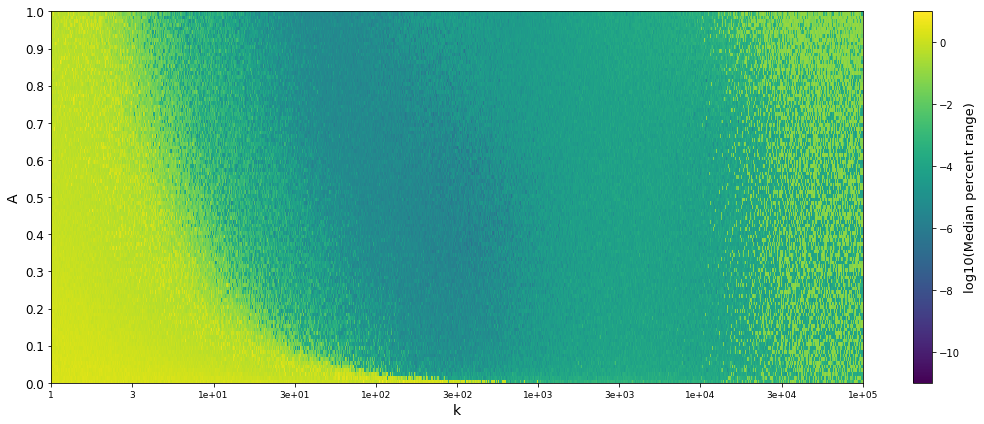

In [588]:
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)
hm = ax.pcolor(np.log10(convMtx.T), vmax=1, vmin=-11)
ax.set_yticks(ticks=np.linspace(0, 100, 11))
ax.set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
ax.set_ylabel('A', fontsize=14)
ax.set_xticks(ticks=np.linspace(0, 1000, 11))
ax.set_xticklabels(labels=['%.g' %i for i in np.logspace(0, 5, 11)], fontsize=9)
ax.set_xlabel('k', fontsize=14)
cbar = plt.colorbar(mappable=hm)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_err1.0_fine.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
import numpy as np
import util

def cal_converge(resList, param):
    convergList = [(np.max(res[param]) - np.min(res[param]))/np.median(res[param]) for res in resList]
    return np.median(convergList)

errs = ['0.0', '0.2', '1.0']
param = 'k'
convList = []

for err in errs:
    convRes = util.load_pickle('/mnt/storage/projects/k-seq/working/archive/fit_simu/convergence_scan_err%s_allRes.pkl' %err)
    convList.append(np.array([[cal_converge(resList, param) for resList in ASet] for ASet in convRes]))

convergence_scan_err0.0_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings, all fitting results preserved
convergence_scan_err0.2_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings, all fitting results preserved
convergence_scan_err1.0_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings, all fitting results preserved


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


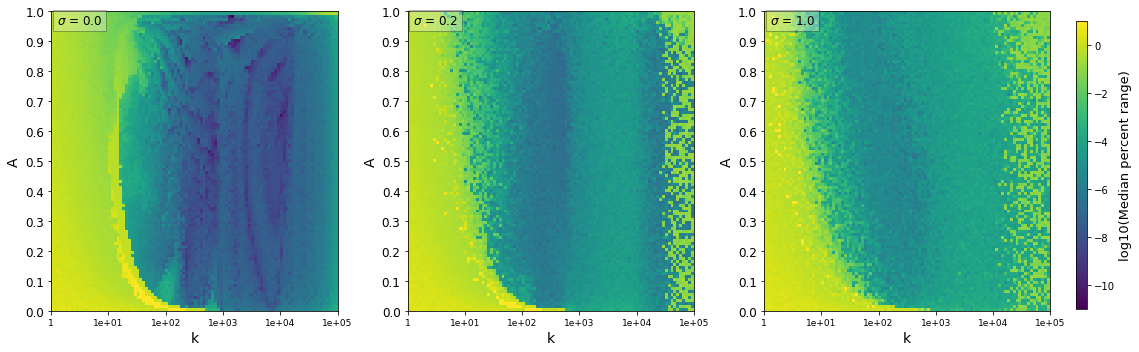

In [110]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(15, 5))

for i in range(3):
    hm = axes[i].pcolor(np.log10(convList[i].T), vmax=1, vmin=-11)
    axes[i].set_yticks(ticks=np.linspace(0, 100, 11))
    axes[i].set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
    axes[i].set_ylabel('A', fontsize=14)
    axes[i].set_xticks(ticks=np.linspace(0, 100, 6))
    axes[i].set_xticklabels(labels=['%.g' %i for i in np.logspace(0, 5, 6)], fontsize=9)
    axes[i].set_xlabel('k', fontsize=14)
    axes[i].text(s=r'$\sigma$ = %s' %errs[i], x=2, y=99, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.3))
ax = fig.add_axes([1,0.13, 0.01, 0.8])
cbar = plt.colorbar(mappable=hm, cax=ax, aspect=50)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
# fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_kA_compare.jpeg', dpi=300, bbox_inches='tight')
plt.show()

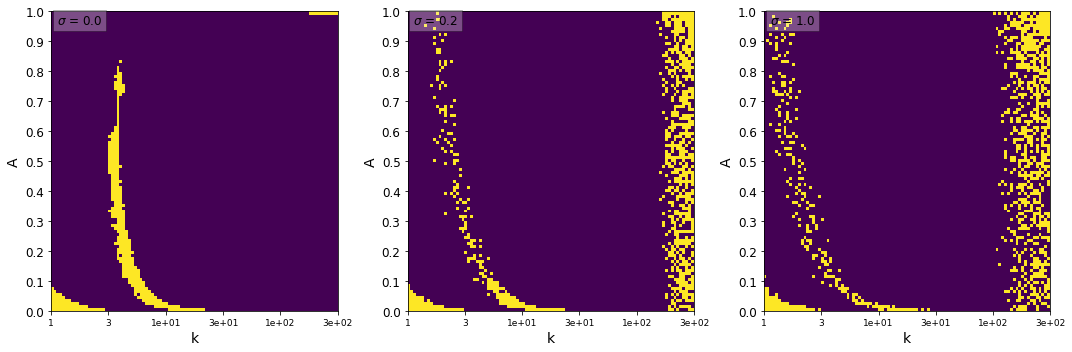

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(15, 5))
threshold = 10**-2

for i in range(3):
    mtx = convList[i].T > threshold
    mtx = mtx.astype(int)
    hm = axes[i].pcolor(mtx)
    axes[i].set_yticks(ticks=np.linspace(0, 100, 11))
    axes[i].set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
    axes[i].set_ylabel('A', fontsize=14)
    axes[i].set_xticks(ticks=np.linspace(0, 100, 6))
    axes[i].set_xticklabels(labels=['%.g' %i for i in np.logspace(0, 5, 11)], fontsize=9)
    axes[i].set_xlabel('k', fontsize=14)
    axes[i].text(s=r'$\sigma$ = %s' %errs[i], x=2, y=99, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.3))
# ax = fig.add_axes([1,0.13, 0.01, 0.8])
# cbar = plt.colorbar(mappable=hm, cax=ax, aspect=50)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_kA_compare_bin.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [99]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(15, 5))
threshold = 10**-2

for i in range(3):
    mtx = convList[i].T > threshold
    mtx = mtx.astype(int)
    hm = axes[i].pcolor(mtx)
    axes[i].set_yticks(ticks=np.linspace(0, 100, 11))
    axes[i].set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
    axes[i].set_ylabel('A', fontsize=14)
    axes[i].set_xticks(ticks=np.linspace(0, 100, 6))
    axes[i].set_xticklabels(labels=['%.g' %i for i in np.logspace(0, 5, 11)], fontsize=9)
    axes[i].set_xlabel('k', fontsize=14)
    axes[i].text(s=r'$\sigma$ = %s' %errs[i], x=2, y=99, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.3))
# ax = fig.add_axes([1,0.13, 0.01, 0.8])
# cbar = plt.colorbar(mappable=hm, cax=ax, aspect=50)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_kA_compare_bin.jpeg', dpi=300, bbox_inches='tight')
plt.show()

0.030229118221443342


12.91549665014884

## Convergence test on different sampling range

In [233]:
import numpy as np
import util

def cal_converge(resList, param):
    convergList = [(np.max(res[param]) - np.min(res[param]))/np.median(res[param]) for res in resList]
    return np.median(convergList)

root = '/mnt/storage/projects/ribozyme_predict/data/k_seq/fit_simu/'
fileList = [
    'convergence_scan_err0.00_x2.0e-06-5.0e-03_allRes.pkl',
    'convergence_scan_err0.20_x2.0e-06-5.0e-03_allRes.pkl'
]
param = 'k'
convList = []

for file in fileList:
    convRes = util.load_pickle(root + file)
    convList.append(np.array([[cal_converge(resList, param) for resList in ASet] for ASet in convRes]))

convergence_scan_err0.00_x2.0e-06-5.0e-03_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings with selected concentration [2.0e-06 2.0e-05 2.5e-04 5.0e-03], all fitting results preserved


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


convergence_scan_err0.20_x2.0e-06-5.0e-03_allRes.pkl:
Scan the convergence of k (res 100), A (res 100), each (k,A) sampled 10 datasets for 10 fittings with selected concentration [2.0e-06 2.0e-05 2.5e-04 5.0e-03], all fitting results preserved


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


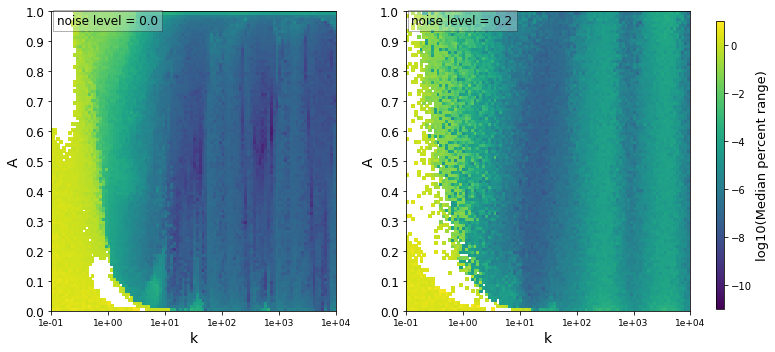

In [222]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10, 5))
labelList = ['noise level = 0.0', 'noise level = 0.2']

for i in range(2):
    hm = axes[i].pcolor(np.log10(convList[i].T), vmax=1, vmin=-11)
    axes[i].set_yticks(ticks=np.linspace(0, 100, 11))
    axes[i].set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
    axes[i].set_ylabel('A', fontsize=14)
    axes[i].set_xticks(ticks=np.linspace(0, 100, 6))
    axes[i].set_xticklabels(labels=['%.e' %i for i in np.logspace(-1, 4, 6)], fontsize=9)
    axes[i].set_xlabel('k', fontsize=14)
    axes[i].text(s=labelList[i], x=2, y=99, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.3))
ax = fig.add_axes([1,0.13, 0.01, 0.8])
cbar = plt.colorbar(mappable=hm, cax=ax, aspect=50)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_k_compare_large_range.jpeg', dpi=300, bbox_inches='tight')
plt.show()

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


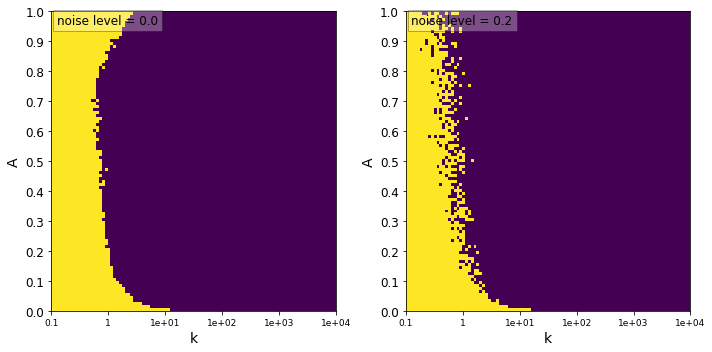

In [234]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10, 5))
threshold = 10**-2

for i in range(2):
    mtx = np.logical_or(convList[i].T > threshold, np.isnan(convList[i].T))
    mtx = mtx.astype(int)
    hm = axes[i].pcolor(mtx)
    axes[i].set_yticks(ticks=np.linspace(0, 100, 11))
    axes[i].set_yticklabels(labels=np.linspace(0, 100, 11)/100, fontsize=12)
    axes[i].set_ylabel('A', fontsize=14)
    axes[i].set_xticks(ticks=np.linspace(0, 100, 6))
    axes[i].set_xticklabels(labels=['%.g' %i for i in np.logspace(-1, 4, 6)], fontsize=9)
    axes[i].set_xlabel('k', fontsize=14)
    axes[i].text(s=labelList[i], x=2, y=99, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.3))
# ax = fig.add_axes([1,0.13, 0.01, 0.8])
# cbar = plt.colorbar(mappable=hm, cax=ax, aspect=50)
cbar.set_label('log10(Median percent range)', fontsize=13)
plt.tight_layout()
fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/convergence_scan_k_compare_large_range_bin.jpeg', dpi=300, bbox_inches='tight')
plt.show()

# play ground

In [81]:
k_seq.data.io.get_file_list(file_root='/mnt/storage/projects/k-seq/input/bfo_counts/')

['/mnt/storage/projects/k-seq/input/bfo_counts/counts',
 '/mnt/storage/projects/k-seq/input/bfo_counts/galaxy_extraction_correction',
 '/mnt/storage/projects/k-seq/input/bfo_counts/pandaSeq_correction',
 '/mnt/storage/projects/k-seq/input/bfo_counts/raw_reads_pooled']

In [58]:
np.log(np.logspace(np.log10(0.1), np.log10(50), 50))

array([-2.30258509, -2.17575636, -2.04892762, -1.92209888, -1.79527015,
       -1.66844141, -1.54161267, -1.41478394, -1.2879552 , -1.16112646,
       -1.03429773, -0.90746899, -0.78064025, -0.65381152, -0.52698278,
       -0.40015404, -0.27332531, -0.14649657, -0.01966783,  0.1071609 ,
        0.23398964,  0.36081838,  0.48764711,  0.61447585,  0.74130459,
        0.86813332,  0.99496206,  1.1217908 ,  1.24861953,  1.37544827,
        1.50227701,  1.62910574,  1.75593448,  1.88276322,  2.00959195,
        2.13642069,  2.26324943,  2.39007816,  2.5169069 ,  2.64373564,
        2.77056438,  2.89739311,  3.02422185,  3.15105059,  3.27787932,
        3.40470806,  3.5315368 ,  3.65836553,  3.78519427,  3.91202301])

In [67]:
k_seq.data.simu.y_value_simulator(x_true=[0.0005, 0.003, 0.001, 0.03], noise=0.3, noise_weighted_as_inverse_mean=True, average=False, params=(0.6, 10), replicates=3, y_allow_zero=True)

(array([0.0005, 0.003 , 0.001 , 0.03  , 0.0005, 0.003 , 0.001 , 0.03  ,
        0.0005, 0.003 , 0.001 , 0.03  ]),
 array([0.31643764, 0.44312559, 0.        , 0.8845887 , 0.32684276,
        0.1200572 , 0.09985921, 0.25876064, 0.        , 0.96705915,
        0.10588595, 0.8010406 ]))

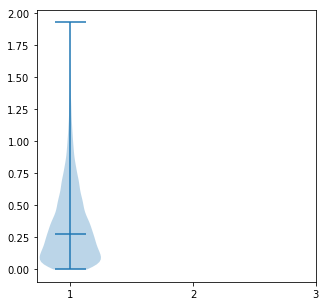

In [33]:
import numpy as np
import matplotlib.pyplot as plt

empirical_sd = [np.std(np.random.normal(size=3, scale=np.random.uniform(low=0.0, high=0.8)), ddof=1) for _ in range(10000)]

fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.violinplot(empirical_sd, showmedians=True)
ax.set_xticks([1, 2, 3])
plt.show()

In [103]:
conv_data = k_seq.data.simu.data_simulator_convergence_map(
    A_range=[0, 1],
    k_range=[0.1, 1000],
    x = [1e-5, 2e-5, 2.5e-4, 1e-3],
    percent_noise=0.2
)

In [104]:
conv_data

{'x': [1e-05, 2e-05, 0.00025, 0.001],
 'y_tensor': array([[[[4.48727079e-07, 8.20196829e-07, 1.28997083e-05,
           3.92732630e-05],
          [2.92899037e-07, 8.14009998e-07, 1.15915253e-05,
           5.48121615e-05],
          [2.72324846e-07, 1.07061866e-06, 8.22653589e-06,
           4.75228290e-05],
          [4.17840094e-07, 9.80148671e-07, 1.19301797e-05,
           4.64513315e-05],
          [3.04676294e-07, 1.08468538e-06, 1.24997486e-05,
           3.95739318e-05]],
 
         [[2.73929785e-07, 7.16978519e-07, 8.94781360e-06,
           3.97901103e-05],
          [4.20337352e-07, 7.66400765e-07, 1.24192490e-05,
           4.82857170e-05],
          [5.20465506e-07, 9.89187107e-07, 9.86603230e-06,
           3.82642116e-05],
          [3.76631210e-07, 9.30126724e-07, 9.91374614e-06,
           4.80518181e-05],
          [4.31681294e-07, 1.02699670e-06, 8.01119061e-06,
           4.96358486e-05]],
 
         [[4.21192318e-07, 1.00549518e-06, 7.75612147e-06,
           5.03

limit_output extension: Maximum message size of 10000 exceeded with 15946 characters

In [74]:
from inspect import signature

def func(x, a1, a2, a3):
    return a1 + a2 + a3

str(signature(func))[1:-1].split(', ')

['x', 'a1', 'a2', 'a3']

In [83]:
x = np.array([0.0002, 0.0005, 0.0010, 0.0050, 0.0250])
y = np.array([0.01, 0.03, 0.06, 0.30, 0.48])
res = fit_analysis.convergence_test(x=x, y=y, weights=None,
                              return_verbose=False,
                              key_value=1,
                              test_size=100)
res

2.8594601998073064e-08

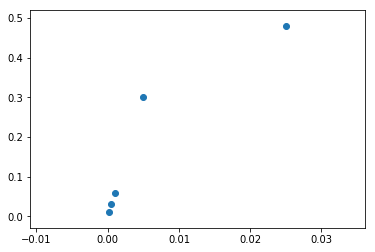

In [41]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

# [Toolbox] Functions used for analysis
## Generate fitting results from random data

In [171]:
import util
print(util.color.BOLD + util.color.BLUE + \
'function to generate the data' + util.color.END)

import numpy as np
from scipy.optimize import curve_fit

def func(x, A, k):
    return A * (1-np.exp(-0.479 * 90 * k * x))

def mse(x, y_, k, A):
    yTrue = A * (1-np.exp(-0.479 * 90 * k * x))
    return np.mean((y_-yTrue)**2)

def param_scan(x, y, kmin, kmax, Amin, Amax, res, klog=True, Alog=False):
    print(util.color.BOLD + util.color.BLUE + \
    'function to scan mse for different k and A' + util.color.END)

    import numpy as np
    
    if Alog:
        xValues = np.logspace(np.log10(Amin), np.log10(Amax), res+1)
    else:
        xValues = np.linspace(Amin, Amax, res+1)
    
    if klog:
        yValues = np.logspace(np.log10(kmin), np.log10(kmax), res+1)
    else:
        yValues = np.linspace(kmin, kmax, res+1)
    
    mapValue = np.array([[mse(x, y, k, A) for A in xValues] for k in np.flip(yValues, axis=0)])
    
    return mapValue, xValues, yValues






function to generate the data


# Simulation of single dataset with multiple fitting trials with different initial value

In [228]:
print(util.color.BOLD + util.color.BLUE + \
'Simulate a single dataset' + util.color.END)


size = 4
xTrue = np.array([0.000002, 0.00001, 0.00002, 0.00025, 0.001, 0.005])
k = 0.5
A = 0.5
err = 0.0

x_,y_ = random_data_generator(k=k, A=A, err=err, xTrue=xTrue, average=True, replicate=3)

print(x_, y_)
fittingRes = fitting_check(k=k, A=A, xTrue=x_, y=y_, size=50)

Simulate a single dataset
[[2.0e-06 1.0e-05 2.0e-05 2.5e-04 1.0e-03 5.0e-03]
 [2.0e-06 1.0e-05 2.0e-05 2.5e-04 1.0e-03 5.0e-03]
 [2.0e-06 1.0e-05 2.0e-05 2.5e-04 1.0e-03 5.0e-03]] [[2.15545354e-05 1.07763385e-04 2.15503545e-04 2.68712837e-03
  1.06621756e-02 5.10852073e-02]
 [2.15545354e-05 1.07763385e-04 2.15503545e-04 2.68712837e-03
  1.06621756e-02 5.10852073e-02]
 [2.15545354e-05 1.07763385e-04 2.15503545e-04 2.68712837e-03
  1.06621756e-02 5.10852073e-02]]


In [229]:
print(util.color.BOLD + util.color.BLUE + \
'Check the mse for simulated data' + util.color.END)

xScan, yScan = np.unravel_index(np.argmin(mapValue), (res+1,res+1))
xValue = xValues[xScan]
yValue = yValues[yScan]
mse(A=xValue, k=yValue, y_=fittingRes['y_'], x=fittingRes['x_'])

Check the mse for simulated data


0.0

In [231]:
print(util.color.BOLD + util.color.BLUE + \
'Quick view of convergence' + util.color.END)

(np.max(fittingRes['k'])-np.min(fittingRes['k']))/np.median(fittingRes['k'])

Quick view of convergence


0.06359880988207738

## Visualization of the fitting results on cost function

function to scan mse for different k and A


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10


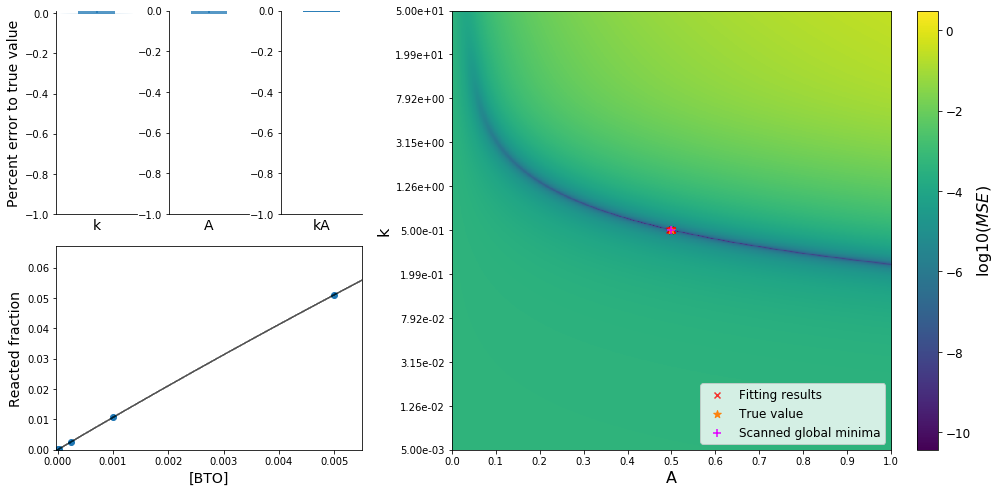

In [197]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_cmplx():
    
    def plot_err():
        gsDist = gs[0,0].subgridspec(1,3, wspace=0.4, hspace=0.0)
    
        axk = plt.subplot(gsDist[0])
        axk.violinplot(fittingRes['kerr'])
        axk.set_xticks([])
        axk.set_xlabel('k', fontsize=14)
        axk.spines['top'].set_visible(False)
        axk.spines['right'].set_visible(False)
        axk.set_ylabel('Percent error to true value', fontsize=14)
        axk.set_ylim([-1, np.max(fittingRes['kerr'])+0.2*np.abs(np.max(fittingRes['kerr']))])
        axk.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        axA = plt.subplot(gsDist[1])
        axA.violinplot(fittingRes['Aerr'])
        axA.set_xticks([])
        axA.set_xlabel('A', fontsize=14)
        axA.spines['top'].set_visible(False)
        axA.spines['right'].set_visible(False)
        axA.set_ylim([-1, np.max(fittingRes['Aerr'])+0.2*np.abs(np.max(fittingRes['Aerr']))])
        axA.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        axkA = plt.subplot(gsDist[0,2])
        axkA.violinplot(fittingRes['kAerr'])
        axkA.set_xticks([])
        axkA.set_xlabel('kA', fontsize=14)
        axkA.spines['top'].set_visible(False)
        axkA.spines['right'].set_visible(False)
        axkA.set_ylim([-1, np.max(fittingRes['kAerr'])+0.2*np.abs(np.max(fittingRes['kAerr']))])
        axkA.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    def plot_curve():
        axcv = plt.subplot(gs[1, 0])
        axcv.scatter(fittingRes['x_'], fittingRes['y_'])
        for ix,k in enumerate(fittingRes['k']):
            x = np.linspace(0, 1.1*np.max(fittingRes['x_']), 1000)
            y = func(A=fittingRes['A'][ix], k=k, x=x)
            axcv.plot(x, y, 'k-', alpha=0.02)
        axcv.set_xlim([-0.00002, 1.1*np.max(fittingRes['x_'])])
        axcv.set_ylim([0, np.max([np.max(y), np.max(fittingRes['y_'])])*1.2])
        axcv.set_xlabel('[BTO]', fontsize=14)
        axcv.set_ylabel('Reacted fraction', fontsize=14)
            
    def plot_heatmap(marks=False):
        axhm = plt.subplot(gs[:, 1])
        hm = axhm.imshow(np.log10(mapValue), vmax=np.max(np.log10(mapValue*10)), cmap='viridis')
        axhm.set_xlabel('A', fontsize=16)
        axhm.set_ylabel('k', fontsize=16, rotation='vertical')
        axhm.set_xlim([0, res])
        axhm.set_ylim([res, 0])
        if marks:
            fittingRes['A'] = np.array(fittingRes['A'])
            fittingRes['k'] = np.array(fittingRes['k'])
            x = fittingRes['A']*res
            y = res-np.log10(fittingRes['k']/kmin)/np.log10(kmax/kmin)*res
            axhm.scatter(x, y, c='#FC0500', marker='x', alpha=0.8, label='Fitting results')
            axhm.scatter(500, 500, c='#FC820D', marker='*', s=64, label='True value')
            xScan, yScan = np.unravel_index(np.argmin(mapValue), (res+1,res+1))
            axhm.scatter(yScan, xScan, c='#E000FF', marker='+', s=64, label='Scanned global minima')
            lg = axhm.legend(loc=4, fontsize=12)
            lg.get_frame().set_facecolor('w')
            
        axhm.set_xticks(np.linspace(0, res, 11))
        axhm.set_xticklabels(labels=['%.1f'%i for i in np.linspace(0, 1, 11)])
        axhm.set_yticks(np.flip(np.linspace(0, res, 11), axis=0))
        axhm.set_yticklabels(labels=['%.2e'%i for i in np.logspace(np.log10(kmin), np.log10(kmax), 11)])
    
        cbar = fig.colorbar(hm, fraction=0.045, pad=0.05)
        cbar.set_label(r'$\log10(MSE)$', fontsize=16)
        cbar.ax.tick_params(labelsize=12)
        
    ## plot_main
    fig = plt.figure(figsize=[14,7], constrained_layout=False)
    gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1,1], width_ratios=[3,5])
    plot_err()
    plot_curve()
    plot_heatmap(marks=True)

    gs.tight_layout(fig)
    
    return fig

############## main

res=1000

kmin = 0.01*k
kmax = 100*k
mapValue, xValues, yValues = param_scan(x=fittingRes['x_'], y=fittingRes['y_'], kmin=kmin, kmax=kmax, klog=True, Amin=0.0, Amax=1.0, Alog=False, res=res)


fig = plot_cmplx()

# fig.savefig('/home/yuning/Work/ribozyme_pred/fig/exp_fit_test/mse_geo_k25000_A0.5_err0.0_stableFit_labeled.jpeg', dpi=300, bbox_inches='tight')

plt.show()